# Compare filtered recommendations
For DBTL2, we used ART to make recommendations based on data from DBTL0/1. To get training data for ART, we filtered strains from DBTL0/1 based on their target expression. 

I made a mistake with the filtering, and when we made recommendations for DBTL2 one extra strain was included in the ART training data. I only noticed this after David already made the strains.

In this notebook, I want to compare the recommendations we made with the recommendations we would have made if we used the correct filtering/training data.

Before running the ART models, on Thursday, March 14th, 2024, I did a `git checkout master`, and then `git rev-parse HEAD`. The returned hash was: fba1d0b7e06099eddc3c32c28a9dc304f43726e9.

I'm also running a comparison on the new (correct) filter with `art_params['seed'] = 42` (dbtl1_new_filter) and `art_params['seed'] = 1` (dbtl1_new_filter_diff_seed)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ART imports

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../../'
# sys.path.append('.')   # Add local directory to access some of the functions
# sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
# import warning_utils
# warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Import the filtered recommendations and the full recommendation dataframes.

In [3]:
new_recs = pd.read_csv('./dbtl1_new_filter/filtered_recs_for_dbtl2.csv')
old_recs = pd.read_csv('./dbtl1_old_filter/filtered_recs_for_dbtl2.csv')
new_recs_full = pd.read_pickle('./dbtl1_new_filter/dbtl1_rec_df_filtered_training_data.pkl')
old_recs_full = pd.read_pickle('./dbtl1_old_filter/dbtl1_rec_df_filtered_training_data.pkl')

Import art models

In [4]:
new_art_fn = './dbtl1_new_filter/art.cpkl'
with open(new_art_fn, 'rb') as output:
    art_new = cloudpickle.load(output)
    
old_art_fn = './dbtl1_old_filter/art.cpkl'
with open(old_art_fn, 'rb') as output:
    art_old = cloudpickle.load(output)

## Compare training data
There should be 3 extra points in the old ART dataframe (3 replicates of the same strain).

In [5]:
print(f'art_NEW df shape: {art_new.df.shape}')
print(f'art_OLD df shape: {art_old.df.shape}')
print(f'Strains not in new df: {[s for s in art_old.df.index if s not in art_new.df.index]}')

art_NEW df shape: (291, 59)
art_OLD df shape: (294, 59)
Strains not in new df: ['PP_0658_PP_0815_PP_4187-R1', 'PP_0658_PP_0815_PP_4187-R2', 'PP_0658_PP_0815_PP_4187-R3']


## Compare the filtered recs between samples

In [6]:
new_recs.head(3)

,Unnamed: 0,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
0,118077,PP_0528_PP_0815_PP_1317_PP_4191,414.533376,66.918579,4,0,1
1,118054,PP_0528_PP_0815_PP_1317_PP_1769,413.431332,67.332116,4,0,1
2,112467,PP_0528_PP_0751_PP_0815_PP_1317,411.722864,66.663143,4,0,1


In [7]:
old_recs.head(3)

,Unnamed: 0,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
0,118077,PP_0528_PP_0815_PP_1317_PP_4191,462.228127,70.068223,4,0,1
1,112467,PP_0528_PP_0751_PP_0815_PP_1317,452.519499,68.659307,4,0,1
2,118054,PP_0528_PP_0815_PP_1317_PP_1769,450.917178,66.723701,4,0,1


## Figure out how many lines are shared between the filtered recs

In [8]:
shared_lines = set(new_recs['line_name'].unique()).intersection(old_recs['line_name'].unique())

In [9]:
print(f'Number of shared lines: {len(shared_lines)}')
_=[print(line) for line in shared_lines]

Number of shared lines: 34
PP_0812_PP_4189
PP_0528_PP_0815_PP_1317_PP_1769
PP_0751_PP_0814
PP_0368_PP_0814
PP_0528_PP_0814_PP_4191
PP_0528_PP_0813_PP_0815_PP_1317
PP_0528_PP_0751_PP_0815_PP_1317
PP_0751_PP_0814_PP_4191
PP_0437_PP_0751_PP_0814
PP_0528_PP_0812_PP_4191
PP_0815_PP_1317_PP_4120
PP_0368_PP_4189
PP_1769_PP_4189
PP_0813_PP_0815_PP_1317
PP_0528_PP_0813_PP_4191
PP_0528_PP_1506_PP_4191
PP_0813_PP_1769
PP_0528_PP_1769_PP_4191
PP_0368_PP_0528_PP_4191
PP_2136_PP_4189
PP_0751_PP_0815_PP_1317
PP_0813_PP_0814
PP_0528_PP_0815_PP_1317
PP_0814_PP_2136
PP_0814_PP_4189
PP_0815_PP_1317_PP_1769
PP_0437_PP_4189
PP_0812_PP_0814
PP_0528_PP_0815_PP_1317_PP_4191
PP_0528_PP_4120_PP_4191
PP_0528_PP_0751_PP_4191
PP_0437_PP_0751_PP_4191
PP_0815_PP_1317_PP_4191
PP_0751_PP_0813_PP_4189


In [10]:
new_recs['shared'] = new_recs['line_name'].apply(lambda x: x in shared_lines)
old_recs['shared'] = old_recs['line_name'].apply(lambda x: x in shared_lines)

## Make a new dataframe for the shared recommendations

In [11]:
df_shared = pd.DataFrame(columns=['line_name'], data = shared_lines)

In [12]:
df_shared['old_mean'] = df_shared['line_name'].apply(lambda x: old_recs.loc[old_recs['line_name']==x, 'pp_mean'].values[0])
df_shared['new_mean'] = df_shared['line_name'].apply(lambda x: new_recs.loc[new_recs['line_name']==x, 'pp_mean'].values[0])
df_shared['old_std'] = df_shared['line_name'].apply(lambda x: old_recs.loc[old_recs['line_name']==x, 'pp_std'].values[0])
df_shared['new_std'] = df_shared['line_name'].apply(lambda x: new_recs.loc[new_recs['line_name']==x, 'pp_std'].values[0])
df_shared.head(3)

,line_name,old_mean,new_mean,old_std,new_std
0,PP_0812_PP_4189,302.034709,305.478410,53.928725,53.220785
1,PP_0528_PP_0815_PP_1317_PP_1769,450.917178,413.431332,66.723701,67.332116
2,PP_0751_PP_0814,336.008559,330.826520,55.240593,54.224446


Text(0, 0.5, 'NEW - predicted mean titer')

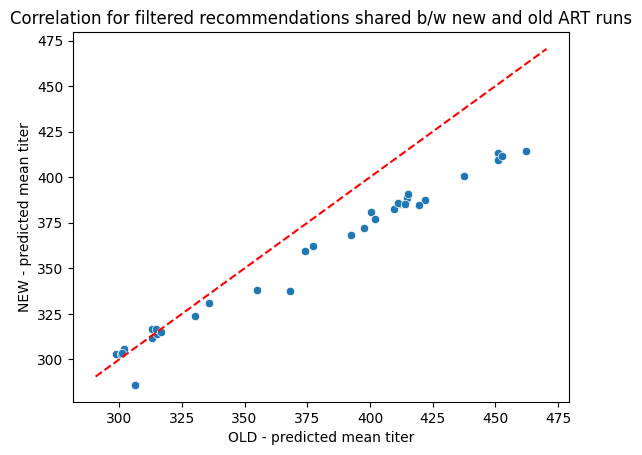

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(df_shared, x = 'old_mean', y = 'new_mean', ax = ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
ax.set_title('Correlation for filtered recommendations shared b/w new and old ART runs')
ax.set_xlabel('OLD - predicted mean titer')
ax.set_ylabel('NEW - predicted mean titer')

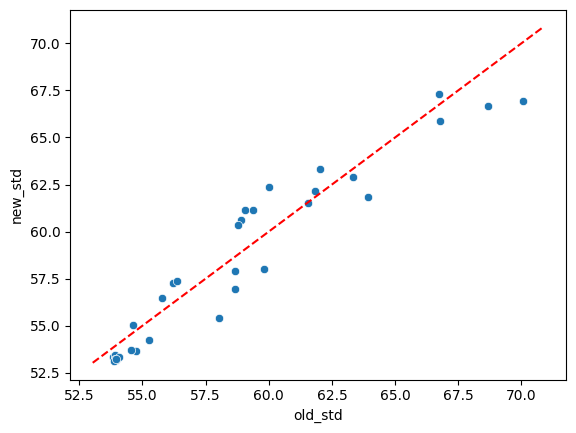

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(df_shared, x = 'old_std', y = 'new_std', ax = ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="red", linestyle="dashed", label="x=y")

## Compare the predictions for all of the recs we made
The recs we made are in `old_recs`, let's see how their predictions compare between the two

In [15]:
old_recs.head(3)

,Unnamed: 0,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec,shared
0,118077,PP_0528_PP_0815_PP_1317_PP_4191,462.228127,70.068223,4,0,1,True
1,112467,PP_0528_PP_0751_PP_0815_PP_1317,452.519499,68.659307,4,0,1,True
2,118054,PP_0528_PP_0815_PP_1317_PP_1769,450.917178,66.723701,4,0,1,True


In [16]:
t = old_recs.loc[0,'line_name']
import re
all_genes = re.findall('PP_[0-9]{4}', t)
new_recs_full.loc[np.all(new_recs_full.loc[:,all_genes], axis = 1)==True,'pp_mean']

118077    414.533376
Name: pp_mean, dtype: float64

In [17]:
new_recs_full.iloc[:, :-2]

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4266,PP_4549,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
425920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
425921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
425922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [18]:
def find_field(df, line_name, field):
    # Get all the genes perturbed from the line name using regex
    all_genes = re.findall('PP_[0-9]{4}', line_name)
    #Find all rows where all genes in the line_name were perturbed 
    rec_idx = np.all(df.loc[:,all_genes], axis = 1)
    #Find all rows where the total number of perturbations matches the number in line_name
    sum_idx = df.iloc[:, :-2].sum(axis = 1) == len(all_genes)
    #Get the values from where we have the correct number of perturbations AND the correct identities
    values = df.loc[rec_idx & sum_idx, field].values
    #Logic for ensuring that we only get one value
    if len(values)==1:
        return values[0]
    else:
        print('0/>2 values detected')
        return None
old_recs['new_model_mean'] = old_recs['line_name'].apply(lambda x: find_field(new_recs_full, x, 'pp_mean'))
old_recs['new_model_std'] = old_recs['line_name'].apply(lambda x: find_field(new_recs_full, x, 'pp_std'))

Text(0.5, 1.0, 'Predicted Mean values of DBTL2 strains')

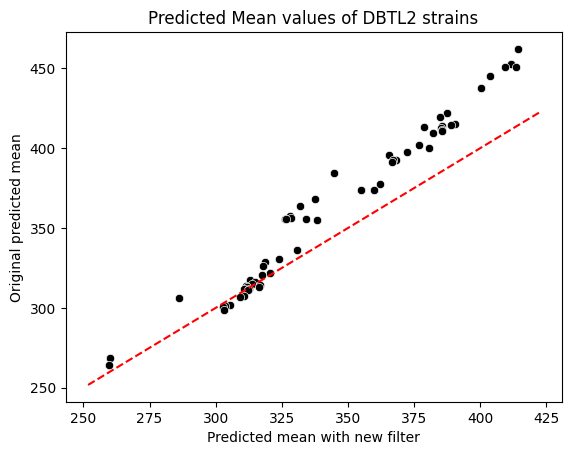

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(old_recs, x = 'new_model_mean', y = 'pp_mean', c = 'k',ax = ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
ax.set_ylabel('Original predicted mean')
ax.set_xlabel('Predicted mean with new filter')
ax.set_title('Predicted Mean values of DBTL2 strains')

Text(0.5, 1.0, 'Predicted StdDev values of DBTL2 strains')

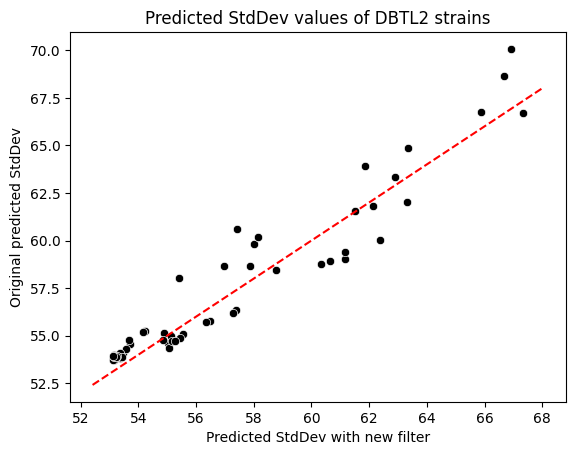

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(old_recs, x = 'new_model_std', y = 'pp_std', c = 'k',ax = ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
ax.set_ylabel('Original predicted StdDev')
ax.set_xlabel('Predicted StdDev with new filter')
ax.set_title('Predicted StdDev values of DBTL2 strains')

Text(0.5, 1.0, 'Mean values')

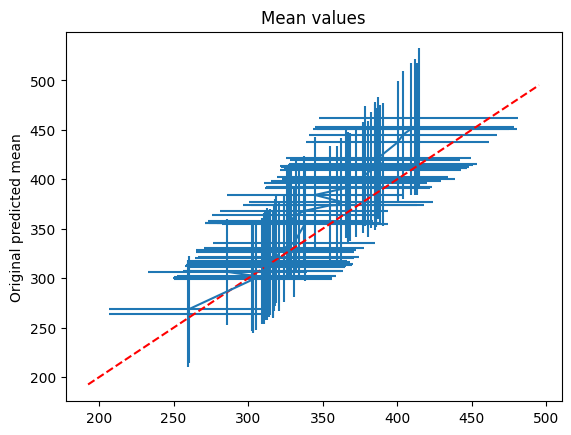

In [21]:
fig, ax = plt.subplots()
plt.errorbar(x = old_recs['new_model_mean'], y = old_recs['pp_mean'], yerr = old_recs['pp_std'], xerr = old_recs['new_model_std'])
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="red", linestyle="dashed", label="x=y")
ax.set_ylabel('Original predicted mean')
ax.set_title('Mean values')

Text(0.5, 1.0, 'Old recs, colored by shared')

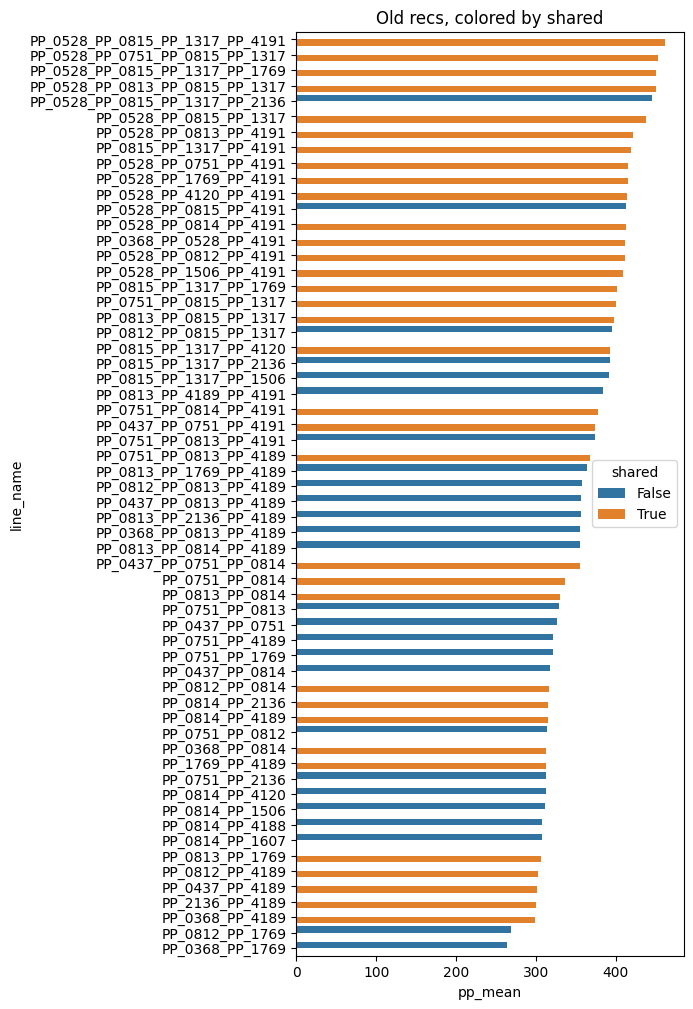

In [22]:
fig, ax = plt.subplots(figsize = (5,12))
sns.barplot(data = old_recs, y = 'line_name', x = 'pp_mean', hue = 'shared')
ax.set_title('Old recs, colored by shared')

Text(0.5, 1.0, 'New recs, colored by shared')

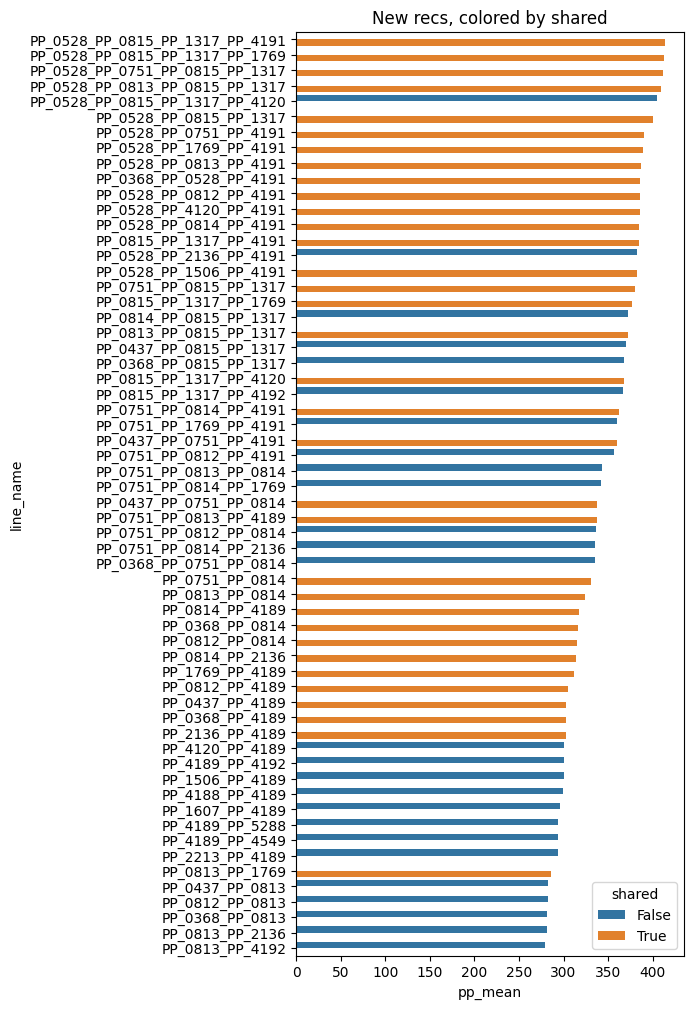

In [23]:
fig, ax = plt.subplots(figsize = (5,12))
sns.barplot(data = new_recs, y = 'line_name', x = 'pp_mean', hue = 'shared')
ax.set_title('New recs, colored by shared')

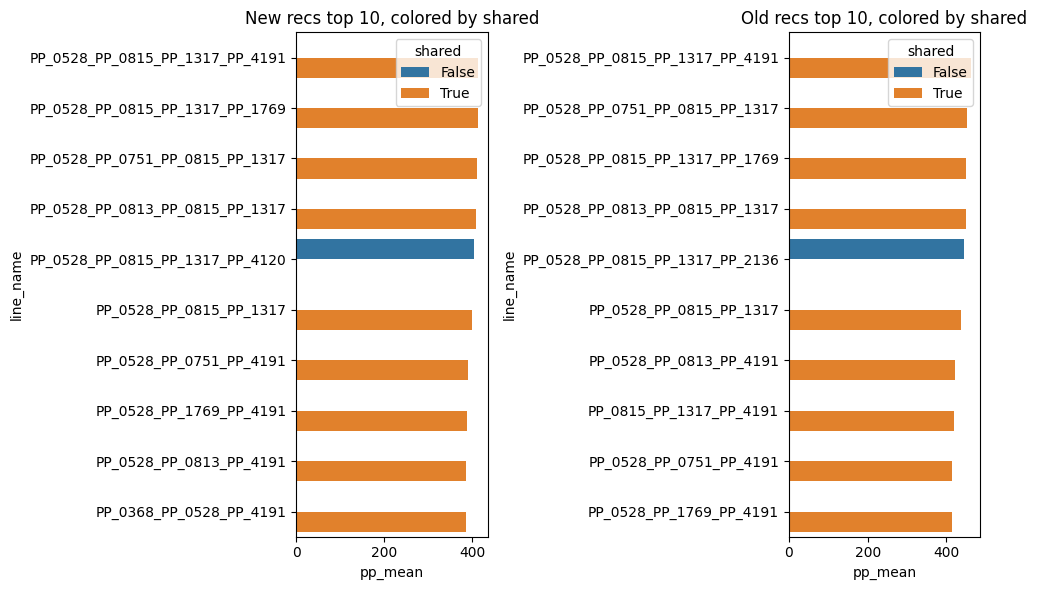

In [24]:
fig, ax = plt.subplots(ncols = 2,figsize = (10,6))
sns.barplot(data = new_recs.head(10), y = 'line_name', x = 'pp_mean', hue = 'shared', ax = ax[0])
ax[0].set_title('New recs top 10, colored by shared')
sns.barplot(data = old_recs.head(10), y = 'line_name', x = 'pp_mean', hue = 'shared', ax = ax[1])
ax[1].set_title('Old recs top 10, colored by shared')
plt.tight_layout()

In [25]:
new_recs

,Unnamed: 0,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec,shared
0,118077,PP_0528_PP_0815_PP_1317_PP_4191,414.533376,66.918579,4,0,1,True
1,118054,PP_0528_PP_0815_PP_1317_PP_1769,413.431332,67.332116,4,0,1,True
2,112467,PP_0528_PP_0751_PP_0815_PP_1317,411.722864,66.663143,4,0,1,True
3,115852,PP_0528_PP_0813_PP_0815_PP_1317,409.293684,65.888204,4,0,1,True
4,118070,PP_0528_PP_0815_PP_1317_PP_4120,405.004953,63.490336,4,0,1,False
5,6456,PP_0528_PP_0815_PP_1317,400.454772,61.503206,3,0,1,True
6,6251,PP_0528_PP_0751_PP_4191,390.607430,63.302183,3,0,1,True
7,6915,PP_0528_PP_1769_PP_4191,388.830625,62.378563,3,0,1,True
8,6395,PP_0528_PP_0813_PP_4191,387.411533,62.131516,3,0,1,True
9,3289,PP_0368_PP_0528_PP_4191,385.669003,61.168985,3,0,1,True
